In [ ]:
Item referenced:
            https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
            https://github.com/keras-team/keras/issues/3296
            https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html
            https://stackoverflow.com/questions/47535596/how-do-i-get-the-true-labels-when-i-use-a-imagedatagenerator-flow-from-directory?rq=1
            https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator
            https://keras.io/preprocessing/image/

In [1]:
# improt the nececssary packages and libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications, optimizers
from keras.utils.np_utils import to_categorical
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import math
import cv2

C:\Python27\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend
C:\Python27\Lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '
C:\Python27\Lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# dimensions of our images.  
img_width, img_height =  150, 150

top_model_weights_path = 'bottleneck_fc_model_weights.h5'
top_model_save_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# number of epochs to train top model  
epochs = 10
# batch size
batch_size = 16
# Hard coded sample sizes
nb_train_samples = 496
nb_validation_samples = 128
n_folds = 3

In [3]:
# This is a function to save the training data features and its labels with the Image Data generator
def save_train_bottlebeck_features(p_train_data_dir, p_img_width, p_img_height, p_batch_size):
    model = applications.VGG16(include_top=False, weights='imagenet')  
    datagen = ImageDataGenerator(rescale=1. / 255)
   
    generator = datagen.flow_from_directory(  
     p_train_data_dir,  
     target_size=(p_img_width, p_img_height),  
     batch_size=p_batch_size,  
     class_mode=None,  
     shuffle=False)  

    l_nb_train_samples = len(generator.filenames)  
    l_num_classes = len(generator.class_indices)
    print("Train num classes ", l_num_classes)

    predict_size_train = int(math.ceil(l_nb_train_samples / float(p_batch_size)))
    print("predict_size_train is ", predict_size_train)
    
    bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train)
    
    print("bottleneck_features_train shape is ", bottleneck_features_train.shape)

    np.save('bottleneck_features_train.npy', bottleneck_features_train) 

In [4]:
def save_validation_bottleneck_features(p_validation_data_dir, p_img_width, p_img_height, p_batch_size):
    model = applications.VGG16(include_top=False, weights='imagenet')  
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    generator = datagen.flow_from_directory(  
     p_validation_data_dir,  
     target_size=(p_img_width, p_img_height),  
     batch_size=p_batch_size,  
     class_mode=None,  
     shuffle=False)  

    l_nb_validation_samples = len(generator.filenames)
    l_num_classes = len(generator.class_indices)
    print("Validation num classes ", l_num_classes)

    predict_size_validation = int(math.ceil(l_nb_validation_samples / float(p_batch_size)))# The float is very important here,
    # else the predict_generator produces smaller numpy array
    print("predict_size_validation is ", predict_size_validation)

    bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
    
    print("bottleneck_features_validation shape is ", bottleneck_features_validation.shape)

    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [5]:
def train_and_evaluate_model(i_fold, train_data, train_labels, p_num_train_classes, validation_data, validation_labels, p_batch_size, p_epochs):
    
    l_num_classes = p_num_train_classes
    model = None
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                            input_shape=train_data.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=1))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(l_num_classes, activation='softmax'))
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='vgg.png')

    #model.summary() 
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

    #model.compile(optimizer='rmsprop',  
    #          loss='categorical_crossentropy', metrics=['accuracy'])
    
    #model.compile(loss='binary_crossentropy',
    #          optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    #          metrics=['accuracy'])

    history = model.fit(train_data, train_labels,  
          epochs=p_epochs,  
          batch_size=p_batch_size,  
          validation_data=(validation_data, validation_labels))  

    model.save_weights(top_model_weights_path + str(i_fold))
    model.save(top_model_save_path + str(i_fold))

    (eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=p_batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss))
    
    plt.figure(1)  

    # summarize history for accuracy  

    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

    # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()

In [6]:
def train_top_model(p_train_data_dir, p_validation_data_dir, p_img_width, p_img_height, p_batch_size, p_epochs):
    datagen_top = ImageDataGenerator(rescale=1./255)  
    generator_top = datagen_top.flow_from_directory(  
         p_train_data_dir,  
         target_size=(p_img_width, p_img_height),  
         batch_size=p_batch_size,  
         class_mode='categorical',  
         shuffle=False)  

    l_nb_train_samples = len(generator_top.filenames)  
    l_num_classes = len(generator_top.class_indices)  

    # load the bottleneck features saved earlier  
    train_data = np.load('bottleneck_features_train.npy')  

    # get the class lebels for the training data, in the original order  
    train_labels_b = generator_top.classes  
    #print(train_labels_b)

    # convert the training labels to categorical vectors  
    train_labels = to_categorical(train_labels_b, num_classes=l_num_classes)
    
    generator_top = datagen_top.flow_from_directory(  
         p_validation_data_dir,  
         target_size=(p_img_width, p_img_height),  
         batch_size=p_batch_size,  
         class_mode=None,  
         shuffle=False)  

    l_nb_validation_samples = len(generator_top.filenames)  

    validation_data = np.load('bottleneck_features_validation.npy')  

    validation_labels = generator_top.classes  
    validation_labels = to_categorical(validation_labels, num_classes=l_num_classes)
    #print(train_labels.shape)
    
    skf = StratifiedKFold(train_labels_b, n_folds=n_folds, shuffle=True)

    for i, (e_train, e_test) in enumerate(skf):
            print "Running Fold", i+1, "/", n_folds
            train_and_evaluate_model(i, train_data[e_train], train_labels[e_train], l_num_classes, train_data[e_test], train_labels[e_test], p_batch_size, p_epochs)

Found 509 images belonging to 32 classes.
Found 128 images belonging to 32 classes.
Running Fold 1 / 3
Train on 319 samples, validate on 190 samples
Epoch 1/10
176/319 [===============>..............] - ETA: 0s - loss: 3.5004 - acc: 0.0398   

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input165") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


319/319 [==============================] - 0s 1ms/step - loss: 3.4801 - acc: 0.0313 - val_loss: 3.3812 - val_acc: 0.1158
Epoch 2/10
319/319 [==============================] - 0s 984us/step - loss: 3.2943 - acc: 0.0627 - val_loss: 3.0391 - val_acc: 0.1211
Epoch 3/10
319/319 [==============================] - 0s 997us/step - loss: 3.0464 - acc: 0.0909 - val_loss: 2.7362 - val_acc: 0.2211
Epoch 4/10
319/319 [==============================] - 0s 887us/step - loss: 2.7606 - acc: 0.1661 - val_loss: 2.4220 - val_acc: 0.3158
Epoch 5/10
319/319 [==============================] - 0s 937us/step - loss: 2.4490 - acc: 0.2759 - val_loss: 2.1890 - val_acc: 0.4000
Epoch 6/10
319/319 [==============================] - 0s 956us/step - loss: 2.1631 - acc: 0.3135 - val_loss: 1.8462 - val_acc: 0.4895
Epoch 7/10
319/319 [==============================] - 0s 871us/step - loss: 1.8968 - acc: 0.3793 - val_loss: 1.5695 - val_acc: 0.5737
Epoch 8/10
319/319 [==============================] - 0s 900us/step - loss:

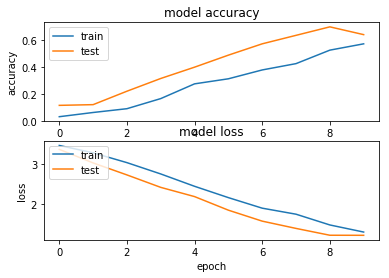

Running Fold 2 / 3
Train on 349 samples, validate on 160 samples
Epoch 1/10
240/349 [===================>..........] - ETA: 0s - loss: 3.4710 - acc: 0.0375

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input1367") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


349/349 [==============================] - 0s 943us/step - loss: 3.4683 - acc: 0.0401 - val_loss: 3.4038 - val_acc: 0.1000
Epoch 2/10
349/349 [==============================] - 0s 851us/step - loss: 3.3135 - acc: 0.0802 - val_loss: 3.0580 - val_acc: 0.1437
Epoch 3/10
349/349 [==============================] - 0s 977us/step - loss: 2.8928 - acc: 0.1547 - val_loss: 2.5344 - val_acc: 0.3000
Epoch 4/10
349/349 [==============================] - 0s 957us/step - loss: 2.4853 - acc: 0.2407 - val_loss: 2.1948 - val_acc: 0.3438
Epoch 5/10
349/349 [==============================] - 0s 865us/step - loss: 2.0914 - acc: 0.3352 - val_loss: 2.0193 - val_acc: 0.4062
Epoch 6/10
349/349 [==============================] - 0s 851us/step - loss: 1.9062 - acc: 0.3897 - val_loss: 1.8295 - val_acc: 0.4437
Epoch 7/10
349/349 [==============================] - 0s 914us/step - loss: 1.6327 - acc: 0.4613 - val_loss: 1.5366 - val_acc: 0.5625
Epoch 8/10
349/349 [==============================] - 0s 857us/step - los

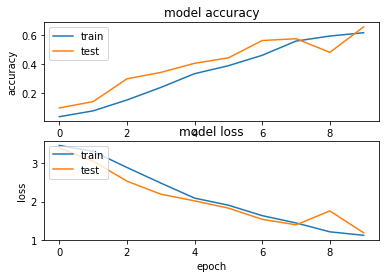

Running Fold 3 / 3
Train on 350 samples, validate on 159 samples
Epoch 1/10
224/350 [==================>...........] - ETA: 0s - loss: 3.4776 - acc: 0.0223  

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2569") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


350/350 [==============================] - 0s 1ms/step - loss: 3.4680 - acc: 0.0257 - val_loss: 3.3820 - val_acc: 0.1132
Epoch 2/10
350/350 [==============================] - 0s 900us/step - loss: 3.2886 - acc: 0.0743 - val_loss: 2.9781 - val_acc: 0.1447
Epoch 3/10
350/350 [==============================] - 0s 854us/step - loss: 2.8941 - acc: 0.1457 - val_loss: 2.4631 - val_acc: 0.2830
Epoch 4/10
350/350 [==============================] - 0s 860us/step - loss: 2.4749 - acc: 0.2486 - val_loss: 2.2251 - val_acc: 0.3333
Epoch 5/10
350/350 [==============================] - 0s 860us/step - loss: 2.2185 - acc: 0.3229 - val_loss: 1.8962 - val_acc: 0.4591
Epoch 6/10
350/350 [==============================] - 0s 931us/step - loss: 1.9337 - acc: 0.4000 - val_loss: 1.5913 - val_acc: 0.5597
Epoch 7/10
350/350 [==============================] - 0s 917us/step - loss: 1.7716 - acc: 0.4229 - val_loss: 1.4847 - val_acc: 0.5535
Epoch 8/10
350/350 [==============================] - 0s 869us/step - loss:

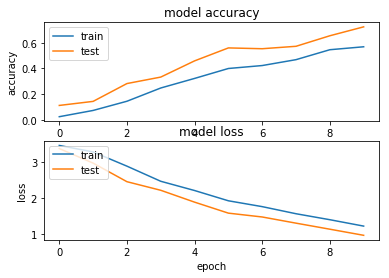

In [7]:
#save_train_bottlebeck_features(train_data_dir, img_width, img_height, batch_size)
#save_validation_bottleneck_features(validation_data_dir, img_width, img_height, batch_size)
train_top_model(train_data_dir, validation_data_dir, img_width, img_height, batch_size, epochs)